# Classifying SumMNIST Dataset using Convolution Neural Network

### Import


In [130]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import torch

### Custom Dataset storing MNIST

Total Number for Summation is 6


In [131]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor


# Custom Data
class MNISTDataset(Dataset):
    def __init__(self, root="", train=True, transform=None):
        path = os.path.join(root, ("train" if train else "test"))
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        self.images = load_images(image_path)
        self.labels = load_labels(label_path)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image).float()

        label = torch.tensor(label, dtype=torch.long)

        return image, label

### Loading Data into the Dataset and DataLoader


In [132]:
train_dataset = MNISTDataset(
    root="mnist",
    train=True,
    transform=ToTensor(),
)


test_dataset = MNISTDataset(
    root="mnist",
    train=False,
    transform=ToTensor(),
)

In [133]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Visualizing the Testing Dataset


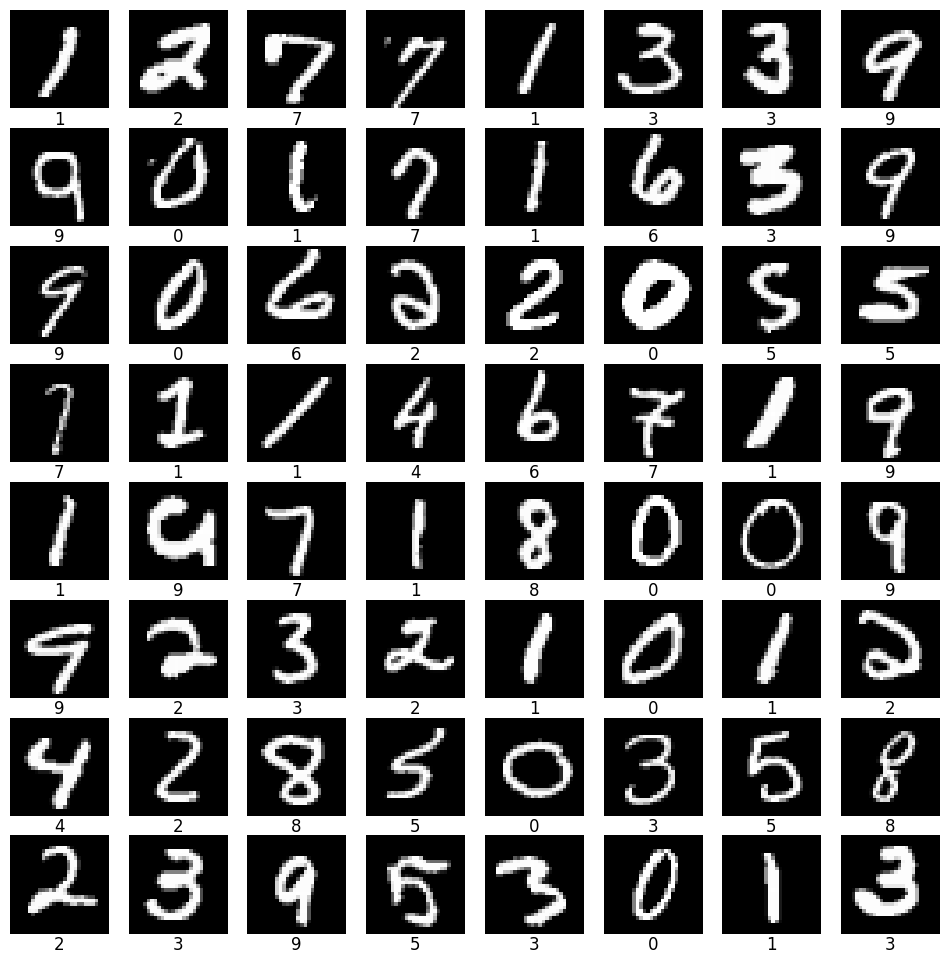

In [134]:
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()


for i, ax in enumerate(axes):

    idx = np.random.randint(len(test_dataset))
    image, label = test_dataset[idx]
    # Squeeze (1, 28, 28) to (28, 28). The 1 in (1, 28, 28) is the batch size
    image = image.squeeze()

    ax.imshow(image, cmap="gray")

    ax.set_title(f"{label}", y=-0.25)
    ax.axis("off")

### Choose the device for execution


In [135]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)


print(f"Using {device} device")

Using cuda device


### Building the Model

#### The Neural Network


In [136]:
from torch import nn
from torch import optim
from torch.nn import init


def initialize_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)


class ConvolutionalNeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.image_processing = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.neural_network = nn.Sequential(
            nn.Linear(in_features=5 * 5 * 20, out_features=10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.image_processing(x)
        x = self.flatten(x)
        x = self.neural_network(x)
        return x


model = ConvolutionalNeuralNetwork().to(device)
# for parameter in model.parameters():
#     print(parameter)

### Loss Tracker


In [137]:
test_losses = []
train_losses = []

#### The Cost Function and Optimizer


In [138]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.002, weight_decay=0.00002)

### Helper Function


In [139]:
def train_model(model, dataloader, loss_function, optimizer):
    model.train()
    losses = 0

    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        # forward propagation
        y_pred = model(x)

        # loss calculation
        loss = loss_function(y_pred, y)
        losses += loss.item()

        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 200 == 0:
            print(
                f"Loss: {loss:>7f}  [{((batch + 1 ) * len(x))}/{len(dataloader.dataset)}]"
            )

    size = len(dataloader.dataset)
    losses /= size
    train_losses.append(losses)


def test_model(model, dataloader, loss_function):
    cost, correct = 0, 0
    model.eval()

    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        loss = loss_function(y_pred, y)

        cost += loss.item()
        correct += torch.eq(torch.argmax(y_pred, dim=1), y).sum().item()

    size = len(dataloader.dataset)
    cost /= size
    correct /= size

    test_losses.append(cost)
    print(f"Test Error:\n Accurarcy: {correct * 100 :<0.1f}%, Cost: {cost :<8f}")

### Training Loop


In [140]:
epoch_size = 10


for i in range(epoch_size):

    print(f"-- Epoch {i + 1} ---------------------------------------------")

    train_model(model, train_dataloader, loss_function, optimizer)

    test_model(model, test_dataloader, loss_function)

-- Epoch 1 ---------------------------------------------
Loss: 2.309324  [64/60000]
Loss: 1.655042  [12864/60000]
Loss: 1.563730  [25664/60000]
Loss: 1.539742  [38464/60000]
Loss: 1.610298  [51264/60000]
Test Error:
 Accurarcy: 89.1%, Cost: 0.024667
-- Epoch 2 ---------------------------------------------
Loss: 1.536521  [64/60000]
Loss: 1.480465  [12864/60000]
Loss: 1.482267  [25664/60000]
Loss: 1.476245  [38464/60000]
Loss: 1.493295  [51264/60000]
Test Error:
 Accurarcy: 98.3%, Cost: 0.023229
-- Epoch 3 ---------------------------------------------
Loss: 1.471426  [64/60000]
Loss: 1.466332  [12864/60000]
Loss: 1.471097  [25664/60000]
Loss: 1.476772  [38464/60000]
Loss: 1.493991  [51264/60000]
Test Error:
 Accurarcy: 98.1%, Cost: 0.023257
-- Epoch 4 ---------------------------------------------
Loss: 1.472368  [64/60000]
Loss: 1.462426  [12864/60000]
Loss: 1.466647  [25664/60000]
Loss: 1.476569  [38464/60000]
Loss: 1.489205  [51264/60000]
Test Error:
 Accurarcy: 98.6%, Cost: 0.023177


### Learning Curve


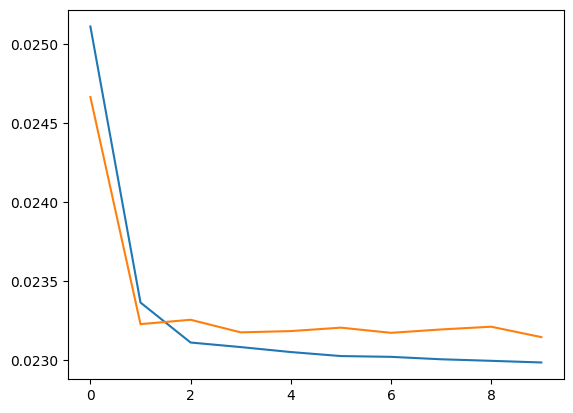

In [141]:
plt.plot(train_losses)
plt.plot(test_losses)

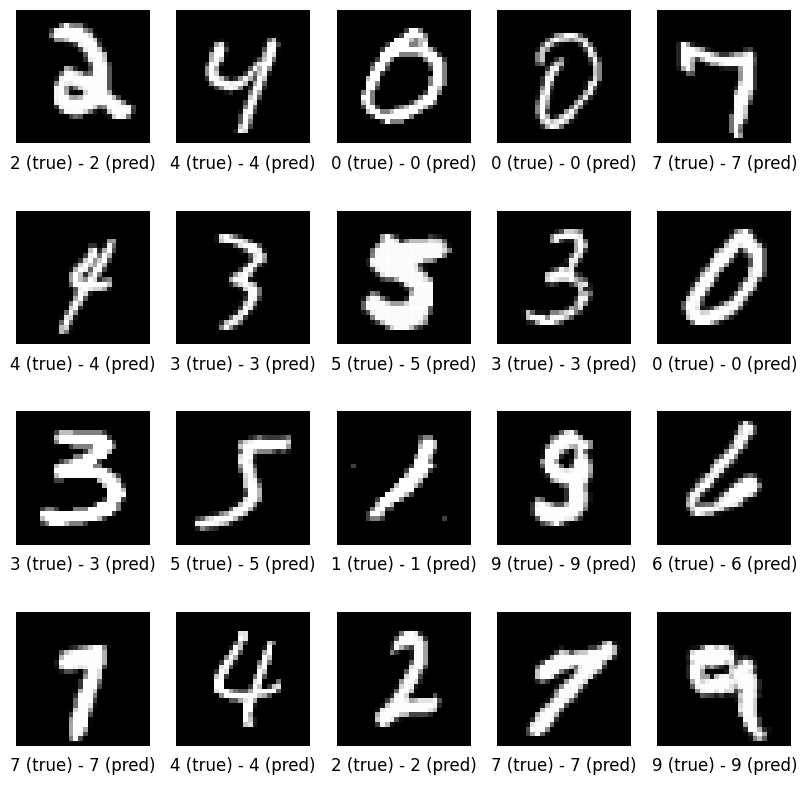

In [143]:
x_test, y_test = next(iter(test_dataloader))
y_pred = model(x_test.to(device)).argmax(1)

fig, axes = plt.subplots(4, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    image = x_test[i].squeeze()
    true_label = y_test[i].item()
    pred_label = y_pred[i].item()

    ax.imshow(image, cmap="gray")
    ax.set_title(f"{true_label} (true) - {pred_label} (pred)", y=-0.25)
    ax.axis("off")